## Credict Card Fraud Detection

### The notebook talks about the idea of changing the Classification thershold in favor of a class and how it affects Precision and Recall. The notebook gives an Intuitive Idea of the Trade off between Accuracy and Precision in the Fraud Detection case. 

In [214]:
## Importing necessary libraries
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

%matplotlib inline

### Loading the Dataset

In [215]:
df=pd.read_csv('creditcard.csv')

In [216]:
df.shape

(284807, 31)

#### Visualizing the Labels Count


Class
0    284315
1       492
dtype: int64


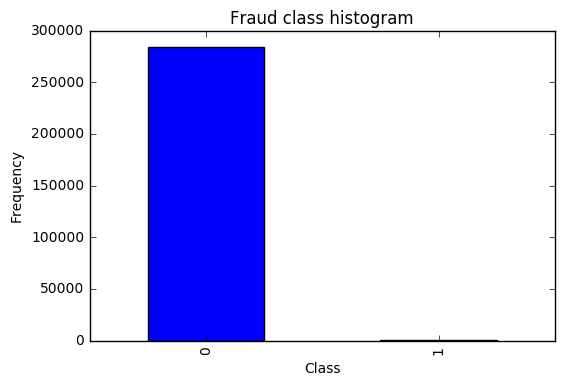

In [217]:
count_classes = pd.value_counts(df['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
Class_split = df.groupby(['Class']).size()
print(Class_split)

#### The Target variable 'Class' consists of 1's and 0's, 
#### 1 indicating a Fraud Transaction
#### 0 indicating a Clean Transaction
#### We see a clear imbalance in the classes, we have 284315 records of a clean transaction and just 492 records (instances) of a Fraud Transaction

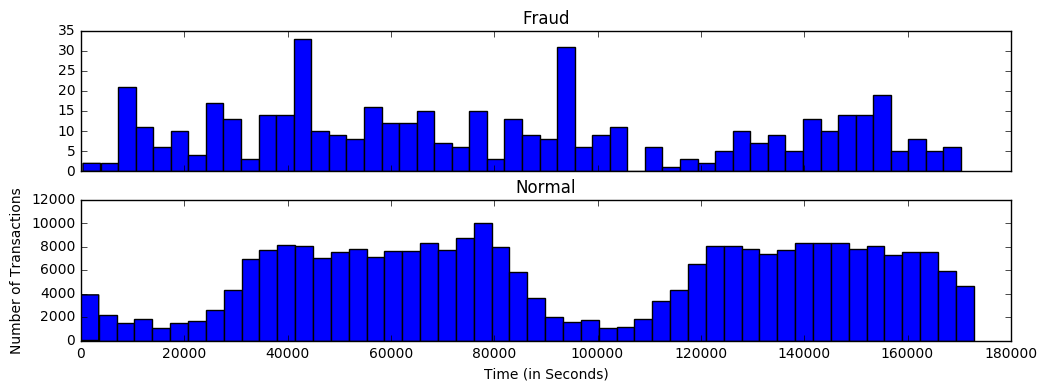

In [218]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(df.Time[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Time[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()


In [219]:
df.isnull().values.any() # We see that there are no missing values in the data set

False

#### Determining the Feature importance using Random forest regressor

In [223]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(1, oob_score = True, random_state =99)
model.fit(features,labels)

C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
           oob_score=True, random_state=99, verbose=0, warm_start=False)

C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from ipykernel import kernelapp as app


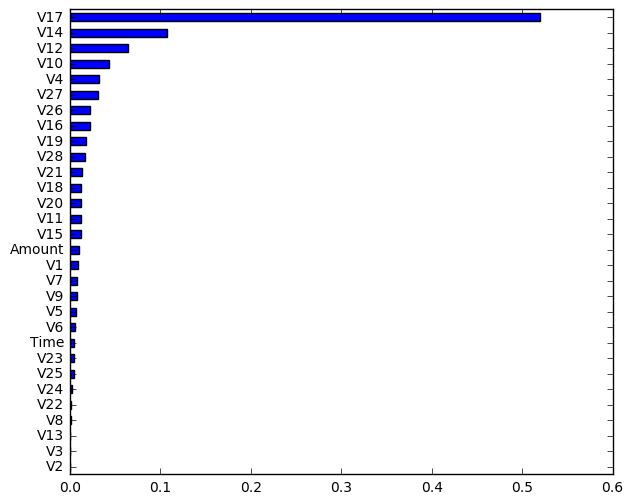

In [224]:
feature_importance = pd.Series(model.feature_importances_, index = features.columns)
feature_importance.sort()
feature_importance.plot( kind = 'barh', figsize = (7,6));

In [128]:
# Dropping the least important Features
df = df.drop(['V2','V8','V9','V5','V3','V23','V18','V6','V25','V24','V28'], axis =1)

#### Preparing the Features and Labels data set from the entire data

In [221]:
columns=df.columns
# The labels are in the last column ('Class'). 
features_columns=columns.delete(len(columns)-1)

features=df[features_columns]
labels=df['Class']

#### Normalizing the 'Time' and 'Amount' Variable

In [222]:
features['Amount'] = (features['Amount'] - features['Amount'].min()) /  (features['Amount'].max() - features['Amount'].min())
features['Time'] = (features['Time'] - features['Time'].min()) /  (features['Time'].max() - features['Time'].min())

C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


#### Splitting the Train and Test set in the ratio of 70:30

In [133]:
features_train, features_test, labels_train, labels_test = train_test_split(features, 
                                                                            labels, 
                                                                            test_size=0.3, 
                                                                            random_state=1)

#### In order to counter the imbalance in the classes, I carried out oversampling via SMOTE

In [134]:
oversampler=SMOTE(random_state=1)
os_features,os_labels=oversampler.fit_sample(features_train,labels_train)

### Building the Classifiers

### 1. Random Forest Classifier

In [3]:
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report, accuracy_score 

In [136]:
clf=RandomForestClassifier(n_estimators = 100, max_depth = 4 ,max_features = 'auto',random_state=99)
clf.fit(os_features,os_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=99, verbose=0, warm_start=False)

In [137]:
actual=labels_test
predictions=clf.predict(features_test)

In [138]:
confusion_matrix(actual,predictions)

array([[84966,   342],
       [   22,   113]], dtype=int64)

In [140]:
print(classification_report(actual,predictions))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85308
          1       0.25      0.84      0.38       135

avg / total       1.00      1.00      1.00     85443



In [145]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print ('AUC:', roc_auc)

AUC: 0.916514017182


#### Observations
#### We were able to correctly identity 113 frauds case of the 135 total fraud cases. 
#### On the other hand 342 Clean transactions were classified as a fraud transaction by the model 
#### Leaving us with a Recall of 0.84 and Precision of 0.25 
#### The AUC achieved was .916

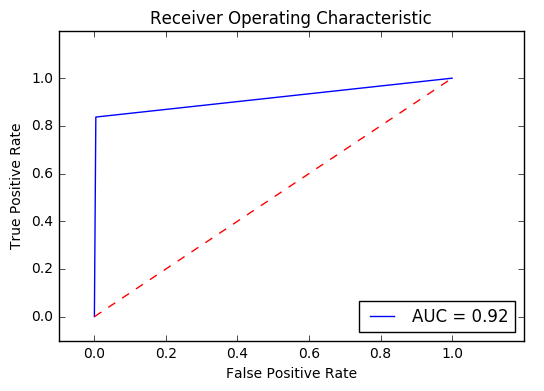

In [146]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### 2. Logistic Regression Model

#### a) Logistic Regression Model With the Default probabilty of 0.5

In [191]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 10,  penalty = 'l1', random_state=99)

In [192]:
lr.fit(os_features,os_labels)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=99, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [193]:
LR_predictions=lr.predict(features_test)

In [194]:
confusion_matrix(labels_test,LR_predictions)

array([[83562,  1746],
       [   16,   119]], dtype=int64)

#### Here we have failed to detect 16 fraud transactions of the total 135 Fraud transactions and misclasified 1745 clean transactions as Fraud

In [195]:
print(classification_report(labels_test,LR_predictions))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99     85308
          1       0.06      0.88      0.12       135

avg / total       1.00      0.98      0.99     85443



In [196]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(labels_test, LR_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print ('AUC:',roc_auc)

AUC: 0.930507233918


### Changing the classification Threshold

### b) Logistic Regression Model With the probabilty of 0.40, if the probabity of being a fraud case is =>.40 we classify it as Fraud case

In [197]:
predprob = lr.predict_proba(features_test) # Getting the probabilty of the classes

In [198]:
predprob

array([[ 0.95568872,  0.04431128],
       [ 0.9877937 ,  0.0122063 ],
       [ 0.96865964,  0.03134036],
       ..., 
       [ 0.77431371,  0.22568629],
       [ 0.99578516,  0.00421484],
       [ 0.88412562,  0.11587438]])

In [199]:
prob_dataframe = pd.DataFrame(predprob)

In [200]:
prob_dataframe['class'] = np.where(prob_dataframe[1] > .40, 1, 0)


In [201]:
prob_dataframe.head(10)

,0,1,class
0,0.955689,0.044311,0
1,0.987794,0.012206,0
2,0.968660,0.031340,0
3,0.986044,0.013956,0
4,0.689284,0.310716,0
5,0.996513,0.003487,0
6,0.564110,0.435890,1
7,0.931505,0.068495,0
8,0.993665,0.006335,0
9,0.996690,0.003310,0


In [202]:
predicted40 = prob_dataframe['class']

In [203]:
confusion_matrix(labels_test,predicted40)

array([[82803,  2505],
       [   12,   123]], dtype=int64)

In [204]:
print(classification_report(labels_test,predicted40))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99     85308
          1       0.05      0.91      0.09       135

avg / total       1.00      0.97      0.98     85443



In [205]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(labels_test, predicted40)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

0.940873462434


#### Observations
#### If the probabilty of a Fraud transaction is => .40 we classiy it as a fraud transaction, this helps capture a more number of fraud cases
#### We were able to correctly identity 123 frauds case of the 135 total fraud cases. 
#### On the other hand 2506 Clean transactions were classified as a fraud transaction by the model 
#### Leaving us with a Recall of 0.91 and Precision of 0.05 
#### AUC achieved was 0.94

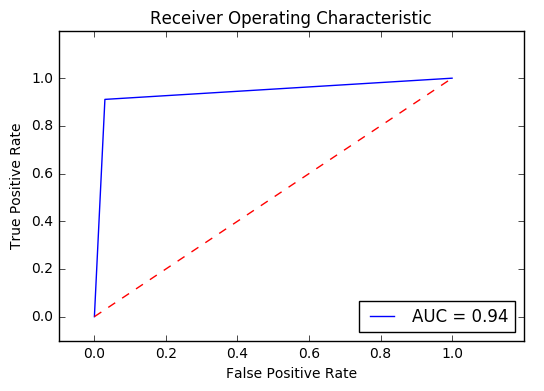

In [161]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### Key Insights 
#### 1. By increasing the classification threshold in favor of Fraud Classes we can detect all the Fraud cases at the expense of losing the precision
#### i.e we classify a lot of Non-Fraud transactions as fraud, which might lead to customer disatisfaction, the bank might potentially lose their customers and the cost incurred by the bank to confirm if the transaction was actually fraud or if it was a False alarm goes Up.
#### 2. The threshold value depends on the cost suffered by the bank for every Fraud Transaction vs cost inccured for having classified a non-fraud transaction as fraud transaction plus the customer disatisfaction for being mistakenly Classified as a Fraud Case.